<a href="https://colab.research.google.com/github/jackpal/colabraytracing/blob/master/Ray_Tracing_in_One_Weekend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Swift Colab version of [Ray Tracing in One Weekend](https://raytracing.github.io/books/RayTracingInOneWeekend.html).

In [1]:
// Setup. (Must be in its own cell because of https://bugs.swift.org/browse/TF-183).
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


Define some helper functions.

In [0]:
import Python

let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

Define a vec3 struct

In [0]:
struct Vec3 {
    var x: Float
    var y: Float
    var z: Float

  init(_ x: Float, _ y: Float, _ z: Float) {
    self.x = x
    self.y = y
    self.z = z
  }

  subscript(index: Int) -> Float {
    get {
      switch(index) {
        case 0: return x
        case 1: return y
        case 2: return z
        default: return 0 // TODO: panic
      }
    }
    set(newValue) {
      switch(index) {
        case 0: x = newValue
        case 1: y = newValue
        case 2: z = newValue
        default: break // TODO: panic
      }
    }
}

  var length: Float {
    squaredLength.squareRoot()
  }

  var squaredLength: Float {
    let x = self.x
    let y = self.y
    let z = self.z
    return x*x + y*y + z*z
  }

  var unitVector: Vec3 {
    return self / length
  }
}

prefix func - (v: Vec3) -> Vec3 {
  Vec3(-v.x, -v.y, -v.z)
}

func + (lhs: Vec3, rhs: Vec3) -> Vec3 {
  Vec3(lhs.x + rhs.x, lhs.y + rhs.y, lhs.z + rhs.z)
}

func - (lhs: Vec3, rhs: Vec3) -> Vec3 {
  Vec3(lhs.x - rhs.x, lhs.y - rhs.y, lhs.z - rhs.z)
}

func * (lhs: Vec3, rhs: Vec3) -> Vec3 {
  Vec3(lhs.x * rhs.x, lhs.y * rhs.y, lhs.z * rhs.z)
}

func * (lhs: Vec3, rhs: Float) -> Vec3 {
  Vec3(lhs.x * rhs, lhs.y * rhs, lhs.z * rhs)
}

func / (lhs: Vec3, rhs: Float) -> Vec3 {
  Vec3(lhs.x / rhs, lhs.y / rhs, lhs.z / rhs)
}

func -=(lhs: inout Vec3, rhs: Vec3) {
  lhs.x -= rhs.x
  lhs.y -= rhs.y
  lhs.z -= rhs.z
}

func +=(lhs: inout Vec3, rhs: Vec3) {
  lhs.x += rhs.x
  lhs.y += rhs.y
  lhs.z += rhs.z
}

func *=(lhs: inout Vec3, rhs: Vec3) {
  lhs.x *= rhs.x
  lhs.y *= rhs.y
  lhs.z *= rhs.z
}

func /=(lhs: inout Vec3, rhs: Vec3) {
  lhs.x /= rhs.x
  lhs.y /= rhs.y
  lhs.z /= rhs.z
}

func *=(lhs: inout Vec3, rhs: Float) {
  lhs.x *= rhs
  lhs.y *= rhs
  lhs.z *= rhs
}

func /=(lhs: inout Vec3, rhs: Float) {
  lhs.x /= rhs
  lhs.y /= rhs
  lhs.z /= rhs
}

func * (lhs: Float, rhs: Vec3) -> Vec3 {
  Vec3(lhs * rhs.x, lhs * rhs.y, lhs * rhs.z)
}

func dot(_ lhs: Vec3, _ rhs: Vec3) -> Float {
  lhs.x * rhs.x + lhs.y * rhs.y + lhs.z * rhs.z
}

func cross(_ v1: Vec3, _ v2: Vec3) -> Vec3 {
    Vec3(v1.y * v2.z - v1.z * v2.y,
        v1.z * v2.x - v1.x * v2.z,
        v1.x * v2.y - v1.y * v2.x)
}

func reflect(_ v: Vec3, _ n: Vec3) -> Vec3 {
  v - 2*dot(v,n)*n
}

typealias Vec3Image = [[Vec3]]

extension Vec3Image {
  func show() {
    plt.imshow(self.map{$0.map{v in [v.x, v.y, v.z].makeNumpyArray()}}, origin:"lower")
    plt.show()
  }
}


In [0]:
struct Ray {
  var origin: Vec3
  var direction: Vec3

  init(_ origin: Vec3, _ direction: Vec3) {
    self.origin = origin
    self.direction = direction
  }
  
  func pointAt(parameter: Float) -> Vec3 {
    origin + parameter * direction
  }
}

In [0]:
struct HitRecord {
  var t: Float
  var p: Vec3
  var normal: Vec3
  var material: Material
}

struct ScatterRecord {
  var attenuation: Vec3
  var scattered: Ray
}

protocol Material {
  func scatter(_ r_in: Ray, _ rec: HitRecord) -> ScatterRecord?
}

protocol Hittable  {
  func hit(_ r: Ray, _ t_min: Float, _ t_max: Float) -> HitRecord?
  func bounding_box(_ t0: Float, _ t1: Float) -> AABB?
}

extension Array : Hittable where Element: Hittable {
  func hit(_ r: Ray, _ t_min: Float, _ t_max: Float) -> HitRecord? {
    var result: HitRecord?
    var closest_so_far = t_max
    self.forEach {item in
      if let hit = item.hit(r, t_min, closest_so_far) {
        closest_so_far = hit.t
        result = hit
      }
    }
    return result
  }

  func bounding_box(_ t0: Float, _ t1: Float) -> AABB? {
    guard count > 0 else {
      return nil
    }
    guard let firstBox = self[0].bounding_box(t0, t1) else {
      return nil
    }
    var result = firstBox
    for i in 1..<count {
      guard let nextBox = self[i].bounding_box(t0, t1) else {
        return nil
      }
      result = surrounding_box(result, nextBox)
    }
    return result
  }
}


func ffmin(_ a: Float, _ b: Float) -> Float {
  a < b ? a : b
}

func ffmax(_ a: Float, _ b: Float) -> Float {
  a > b ? a : b
}

struct AABB {
  var min: Vec3
  var max: Vec3
  
  init(_ min: Vec3, _ max: Vec3) {
    self.min = min
    self.max = max
  }
  
  func hit(_ r: Ray, _ tmin: Float, _ tmax: Float) -> Bool {
    for a in 0..<3 {
      let invD = 1.0 / r.direction[a]
      var t0 = (min[a] - r.origin[a]) * invD
      var t1 = (max[a] - r.origin[a]) * invD
      if invD < 0.0 {
        swap(&t0, &t1)
      }
      let tmin2 = t0 > tmin ? t0 : tmin
      let tmax2 = t1 < tmax ? t1 : tmax
      if tmax2 <= tmin2 {
        return false
      }
    }
    return true
  }
}

struct BVHNode : Hittable {
  var box: AABB
  var left: Hittable
  var right: Hittable
  
  func hit(_ r: Ray, _ t_min: Float, _ t_max: Float) -> HitRecord? {
    guard box.hit(r, t_min, t_max) else {
      return nil
    }
    if let left_rec = left.hit(r, t_min, t_max) {
      if let right_rec = right.hit(r, t_min, t_max) {
        if (left_rec.t < right_rec.t) {
          return left_rec
        } else {
          return right_rec
        }
      } else {
        return left_rec
      }
    } else {
      return right.hit(r, t_min, t_max)
    }
  }
  
  func bounding_box(_ t0: Float, _ t1: Float) -> AABB? {
    box
  }
  
  init(_ hittables: [Hittable], _ t0: Float, _ t1: Float) {
    self.init(hittables[0...], t0, t1)
  }
  
  init(_ hittables: ArraySlice<Hittable>, _ t0: Float, _ t1: Float) {
    let axis = Int.random(in: 0..<3)
    let items = hittables.sorted { a, b in
      a.bounding_box(t0, t1)!.min[axis] < b.bounding_box(t0, t1)!.min[axis]
    }
    if items.count == 1 {
      left = items[0]
      right = items[0]
    } else if items.count == 2 {
      left = items[0]
      right = items[1]
    } else {
      let splitIndex = items.count / 2
      left = BVHNode(items[..<splitIndex], t0, t1)
      right = BVHNode(items[splitIndex...], t0, t1)
    }
    box = surrounding_box(left.bounding_box(t0, t1)!, right.bounding_box(t0, t1)!)
  }
}

func surrounding_box(_ box0: AABB , _ box1: AABB) -> AABB {
    let small = Vec3( ffmin(box0.min.x, box1.min.x),
                ffmin(box0.min.y, box1.min.y),
                ffmin(box0.min.z, box1.min.z))
    let big = Vec3( ffmax(box0.max.x, box1.max.x),
                ffmax(box0.max.y, box1.max.y),
                ffmax(box0.max.z, box1.max.z))
    return AABB(small,big)
}

struct Sphere: Hittable {
  var center: Vec3
  var radius: Float
  var material: Material
  
  func hit(_ r: Ray, _ t_min: Float, _ t_max: Float) -> HitRecord? {
    let oc = r.origin - center
    let a = dot(r.direction, r.direction)
    let b = dot(oc, r.direction)
    let c = dot(oc, oc) - radius*radius
    let discriminant = b*b - a*c
    if discriminant > 0 {
      let temp = (-b - discriminant.squareRoot())/a
      if temp < t_max && temp > t_min {
        let p = r.pointAt(parameter:temp)
        return HitRecord(t: temp, p: p, normal: (p-center) / radius, material: material)
      }
      let temp2 = (-b + discriminant.squareRoot()) / a
      if temp2 < t_max && temp2 > t_min {
        let p = r.pointAt(parameter:temp2)
        return HitRecord(t: temp2, p: p, normal: (p-center) / radius, material: material)
      }
    }
    return nil
  }
    
  func bounding_box(_ t0: Float, _ t1: Float) -> AABB? {
    let r3 = Vec3(radius, radius, radius)
    return AABB(center - r3, center + r3)
  }
}

func random_float() -> Float {
  Float.random(in: 0..<1)
}

func random_in_unit_sphere() -> Vec3 {
  var p: Vec3
  repeat {
    p = 2.0*Vec3(random_float(), random_float(), random_float()) - Vec3(1,1,1)
  } while p.squaredLength >= 1.0
  return p
}

struct Lambertian : Material {
  var albedo: Vec3
  func scatter(_ r_in: Ray, _ rec: HitRecord) -> ScatterRecord? {
    let target = rec.p + rec.normal + random_in_unit_sphere()
    return ScatterRecord(attenuation:albedo, scattered:Ray(rec.p, target-rec.p))
  }
}

struct Metal: Material {
  var albedo: Vec3
  var fuzz: Float

  init(albedo: Vec3, fuzz: Float) {
    self.albedo = albedo
    self.fuzz = min(fuzz, 1.0)
  }

  func scatter(_ r_in: Ray, _ rec: HitRecord) -> ScatterRecord? {
    let reflected = reflect(r_in.direction.unitVector, rec.normal)
    let scattered = Ray(rec.p, reflected + fuzz*random_in_unit_sphere())
    let attenuation = albedo
    if dot(scattered.direction, rec.normal) > 0 {
      return ScatterRecord(attenuation:attenuation, scattered:scattered)
    }
    return nil
  }
}

In [0]:
func random_in_unit_disk() -> Vec3 {
    var p: Vec3
    repeat {
        p = 2.0*Vec3(random_float(), random_float(),0) - Vec3(1,1,0)
    } while (dot(p,p) >= 1.0)
    return p
}

struct Camera {
  var origin: Vec3
  var lower_left_corner: Vec3
  var horizontal: Vec3
  var vertical: Vec3
  var u: Vec3
  var v: Vec3
  var w: Vec3
  var lens_radius: Float

  init(_ lookfrom: Vec3, _ lookat: Vec3,  _ vup: Vec3, _ vfov: Float,
    _ aspect: Float, _ aperture: Float, _ focus_dist: Float) {
    lens_radius = aperture / 2
    // vfov is top to bottom in degrees
    let theta = vfov*Float.pi/180
    let half_height = Float.tan(theta/2)
    let half_width = aspect * half_height
    origin = lookfrom
    w = (lookfrom - lookat).unitVector
    u = cross(vup, w).unitVector
    v = cross(w, u)
    lower_left_corner = origin
      - half_width * focus_dist * u
      - half_height * focus_dist * v
      - focus_dist * w
    horizontal = 2*half_width*focus_dist*u
    vertical = 2*half_height*focus_dist*v
  }

  func get_ray(_ s: Float, _ t: Float) -> Ray {
    let rd = lens_radius * random_in_unit_disk()
    let offset = u * rd.x + v * rd.y
    return Ray(origin + offset, 
      lower_left_corner + s*horizontal + t*vertical - origin - offset)
  }
}

func skyColor(_ r:Ray) -> Vec3 {
  let unit_direction = r.direction.unitVector
  let t = 0.5*(unit_direction.y + 1.0)
  return (1.0-t)*Vec3(1.0, 1.0, 1.0) + t*Vec3(0.5, 0.7, 1.0)
}

func color(r: Ray, world: Hittable, depth: Int) -> Vec3 {
  if let rec = world.hit(r, 0.001, Float.greatestFiniteMagnitude) {
    if depth < 50 {
      if let scatRec = rec.material.scatter(r, rec) {
        return scatRec.attenuation * color(r: scatRec.scattered, world: world, depth: depth + 1)
      }
    }
      return 0.5*Vec3(rec.normal.x+1, rec.normal.y+1, rec.normal.z+1)
  }
  else {
    return skyColor(r)
  }
}

func trace(camera: Camera, world: Hittable) {
  let nx = 200
  let ny = 100
  let ns = 100 // 100 samples seems excessive for anti-aliasing.
  (0..<ny).map { (j: Int) -> [Vec3] in
    return (0..<nx).map { (i: Int) -> Vec3 in
      var col = Vec3(0, 0, 0)
      (0..<ns).forEach { _ in
        let u = (Float(i) + random_float()) / Float(nx)
        let v = (Float(j) + random_float()) / Float(ny)
        let r = camera.get_ray(u, v)
        col += color(r: r, world: world, depth:0)
      }
      col /= Float(ns)
      // Gamma correction
      col = Vec3(col.x.squareRoot(), col.y.squareRoot(), col.z.squareRoot() )
      return col
    }
  }.show()
}


In [0]:
func sqrt(_ f: Float) -> Float {
  f.squareRoot()
}

func refract(_ v: Vec3, _ n: Vec3, _ ni_over_nt: Float) -> Vec3? {
  let uv = v.unitVector
  let dt = dot(uv, n)
  let discriminant = 1.0 - ni_over_nt*ni_over_nt*(1-dt*dt)
  if discriminant > 0 {
    return ni_over_nt*(uv - n*dt) - n*sqrt(discriminant)
  }
  return nil // Total internal reflection.
}

func schlick(_ cosine: Float, _ ref_idx: Float) -> Float {
    var r0 = (1-ref_idx) / (1+ref_idx)
    r0 = r0*r0
    return r0 + (1-r0)*Float.pow((1 - cosine), 5)
}

struct Dielectric : Material {
  var refractiveIndex : Float
  func scatter(_ r_in: Ray, _ rec: HitRecord) -> ScatterRecord? {
    var outward_normal: Vec3
    let reflected = reflect(r_in.direction, rec.normal)
    var ni_over_nt: Float
    let attenuation = Vec3(1.0, 1.0, 1.0)

    var reflect_prob: Float
    var cosine: Float

    if dot(r_in.direction, rec.normal) > 0 {
        outward_normal = -rec.normal
        ni_over_nt = refractiveIndex
        cosine = refractiveIndex * dot(r_in.direction, rec.normal)
                        / r_in.direction.length;
    } else {
        outward_normal = rec.normal
        ni_over_nt = 1.0 / refractiveIndex
        cosine = -dot(r_in.direction, rec.normal)
                        / r_in.direction.length
    }

    var scattered = Ray(rec.p, reflected)
    if let refracted = refract(r_in.direction, outward_normal, ni_over_nt) {
      reflect_prob = schlick(cosine, refractiveIndex)
      if random_float() >= reflect_prob {
        scattered = Ray(rec.p, refracted)
      }
    }
    
    return ScatterRecord(attenuation: attenuation, scattered: scattered)
  }
}


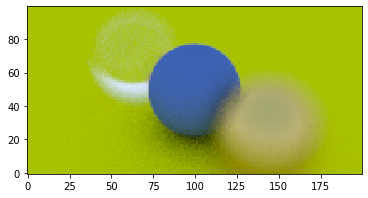

In [8]:
func bigApertureCamera() -> Camera {
  let lookfrom = Vec3(3,3,2)
  let lookat = Vec3(0,0,-1)
  let dist_to_focus = (lookfrom-lookat).length
  let aperture: Float = 2.0
  return Camera(lookfrom, lookat, Vec3(0,1,0), 20,
           2.0, aperture, dist_to_focus)
}

trace(camera: bigApertureCamera(), world: BVHNode([
    Sphere(center:Vec3(0,0,-1), radius:0.5, material:Lambertian(albedo:Vec3(0.1, 0.2, 0.5))),
    Sphere(center:Vec3(0,-100.5,-1), radius:100, material: Lambertian(albedo:Vec3(0.8, 0.8, 0.0))),
    Sphere(center:Vec3(1,0,-1), radius:0.5, material: Metal(albedo:Vec3(0.8, 0.6, 0.2), fuzz:0.0)),
    Sphere(center:Vec3(-1,0,-1), radius:0.5, material: Dielectric(refractiveIndex:1.5)),
    Sphere(center:Vec3(-1,0,-1), radius:-0.45, material: Dielectric(refractiveIndex:1.5))
  ], 0, 1))

13. Where Next?


In [0]:
func random_scene() -> Hittable {
    var list: [Sphere] = []
    list.append(Sphere(
      center:Vec3(0,-1000,0),
      radius:1000,
      material:Lambertian(albedo:Vec3(0.5, 0.5, 0.5))
    ))
    for a in -11..<11 {
      for b in -11..<11 {
        let choose_mat = random_float()
        let center = Vec3(Float(a)+0.9*random_float(),0.2,Float(b)+0.9*random_float())
        if (center-Vec3(4,0.2,0)).length > 0.9 {
          if choose_mat < 0.8 {  // diffuse
            list.append(Sphere(center:center, radius:0.2,
                material:Lambertian(albedo:Vec3(random_float()*random_float(),
                                    random_float()*random_float(),
                                    random_float()*random_float())
                )
            ))
          }
          else if choose_mat < 0.95 { // metal
            list.append(Sphere(center:center, radius:0.2,
                    material:Metal(albedo:Vec3(0.5*(1 + random_float()),
                                    0.5*(1 + random_float()),
                                    0.5*(1 + random_float())),
                              fuzz:0.5*random_float())))
          }
          else {  // glass
            list.append(Sphere(center:center, radius:0.2, material:Dielectric(refractiveIndex:1.5)))
          }
        }
      }
    }
    list.append(Sphere(center:Vec3(0, 1, 0), radius:1.0, material:Dielectric(refractiveIndex:1.5)))
    list.append(Sphere(center:Vec3(-4, 1, 0), radius:1.0, material:Lambertian(albedo:Vec3(0.4, 0.2, 0.1))))
    list.append(Sphere(center:Vec3(4, 1, 0), radius:1.0, material:Metal(albedo:Vec3(0.7, 0.6, 0.5), fuzz:0.0)))

    return BVHNode(list, 0, 1)
}

func bigPictureCamera() -> Camera {
  let lookfrom = Vec3(13,2,3)
  let lookat = Vec3(0,0,0)
  let dist_to_focus: Float = 10.0
  let aperture: Float = 0.0
  return Camera(
    lookfrom, lookat, Vec3(0,1,0), 20, 2.0, aperture,
    dist_to_focus)
}


Takes a long time to run. (1 minute when run locally on iMac Pro)

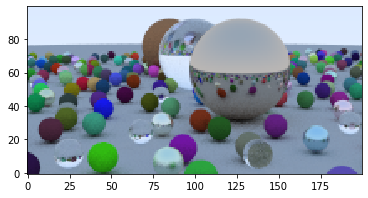

In [10]:
trace(camera: bigPictureCamera(), world: random_scene())